In [31]:
import torch
import torch.nn.functional as F
from torch import nn, optim

import torchvision
from torchvision import datasets, transforms

import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [2]:
# Define a transform to normalize data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [4]:
model = Classifier()

images, labels = next(iter(testloader))

prob = torch.exp(model(images))

print(prob.shape)

torch.Size([64, 10])


In [5]:
top_prob, top_class = prob.topk(1, dim=1)
print(top_class[:10, :])

tensor([[1],
        [1],
        [9],
        [1],
        [9],
        [9],
        [1],
        [9],
        [1],
        [9]])


In [6]:
equals = top_class == labels.view(*top_class.shape)
print(equals.shape)
print(equals.dtype)

torch.Size([64, 1])
torch.uint8


In [7]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item() * 100}%')

Accuracy: 9.375%


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using: {}".format(device))
print(torch.cuda.get_device_name(0))

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

Using: cuda:0
GeForce GTX 1060


In [30]:
train_losses, test_losses = [], []
for e in range(epochs):
    train_loss = 0
    
    for images, labels in trainloader:
        images.to(device)
        labels.to(device)
        
        optimizer.zero_grad()
        
        y_hat = model(images)
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off the gradient for validation
        with torch.no_grad():
            for images, labels in testloader:
                images.to(device)
                labels.to(device)
        
                y_hat = model(images)
                test_loss += criterion(y_hat, labels)
                
                prob = torch.exp(y_hat)
                top_prob, top_class = prob.topk(1, dim=1)
                equals = top_class == labels.view((*top_class.shape))
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}.. ".format(accuracy/len(testloader))
             )

Epoch: 1/30..  Training Loss: 0.510..  Test Loss: 0.452..  Test Accuracy: 0.841.. 
Epoch: 2/30..  Training Loss: 0.395..  Test Loss: 0.401..  Test Accuracy: 0.858.. 
Epoch: 3/30..  Training Loss: 0.355..  Test Loss: 0.403..  Test Accuracy: 0.854.. 
Epoch: 4/30..  Training Loss: 0.331..  Test Loss: 0.401..  Test Accuracy: 0.856.. 
Epoch: 5/30..  Training Loss: 0.312..  Test Loss: 0.379..  Test Accuracy: 0.870.. 
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.378..  Test Accuracy: 0.870.. 
Epoch: 7/30..  Training Loss: 0.291..  Test Loss: 0.371..  Test Accuracy: 0.871.. 
Epoch: 8/30..  Training Loss: 0.279..  Test Loss: 0.357..  Test Accuracy: 0.877.. 
Epoch: 9/30..  Training Loss: 0.267..  Test Loss: 0.357..  Test Accuracy: 0.882.. 
Epoch: 10/30..  Training Loss: 0.269..  Test Loss: 0.367..  Test Accuracy: 0.875.. 
Epoch: 11/30..  Training Loss: 0.254..  Test Loss: 0.376..  Test Accuracy: 0.875.. 
Epoch: 12/30..  Training Loss: 0.252..  Test Loss: 0.361..  Test Accuracy: 0.879.. 
E

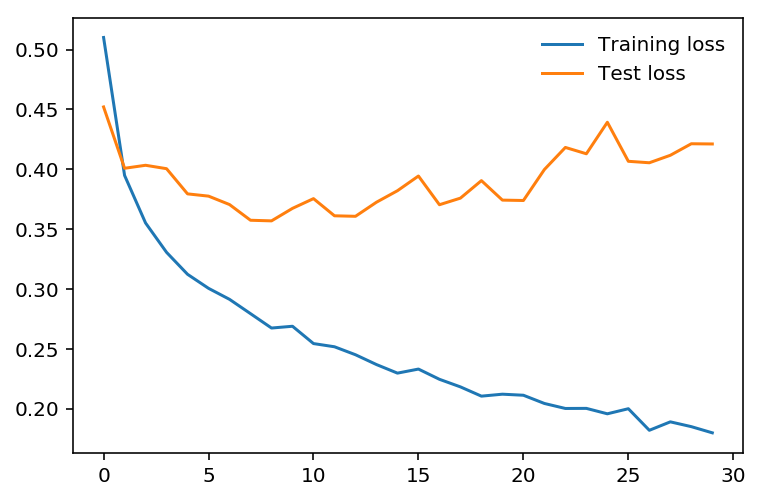

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)

This is an overfitting